<a href="https://colab.research.google.com/github/ChJazhiel/VAE_NBody/blob/main/Matter_Power_spectrum_postprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Raw power spectrum extraction from data

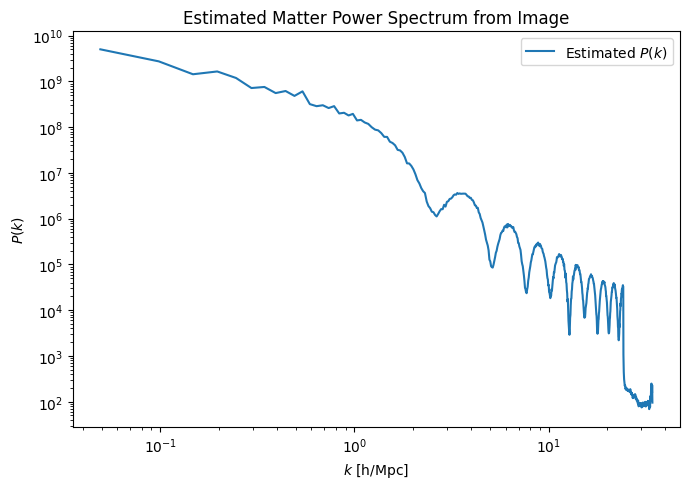

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.fft import fft2, fftshift

# Load the image and convert to grayscale array
image_path = "/content/fake_sample.png"
image = Image.open(image_path).convert("L")
image_array = np.array(image, dtype=np.float32)

# Normalize the image
image_array -= np.mean(image_array)
image_array /= np.std(image_array)

# Calculate 2D FFT and shift zero frequency to center
fft_image = fftshift(fft2(image_array))
power_spectrum_2d = np.abs(fft_image) ** 2

# Define radial bins for k
ny, nx = power_spectrum_2d.shape
y, x = np.indices((ny, nx))
center = np.array([ny // 2, nx // 2])
r = np.sqrt((x - center[1])**2 + (y - center[0])**2)
r = r.astype(np.int32)

# Radially average the power spectrum
tbin = np.bincount(r.ravel(), power_spectrum_2d.ravel())
nr = np.bincount(r.ravel())
radial_profile = tbin / nr

# Construct k values assuming a scale
box_size = 128  # Mpc/h
k_radial = np.arange(len(radial_profile)) * (2 * np.pi / box_size)

# Plot the power spectrum
plt.figure(figsize=(7, 5))
plt.loglog(k_radial[1:], radial_profile[1:], label='Estimated $P(k)$')
plt.xlabel('$k$ [h/Mpc]')
plt.ylabel('$P(k)$')
plt.title('Estimated Matter Power Spectrum from Image')
#plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Gaussian filtering and $\Lambda$CDM Toy Model comparison


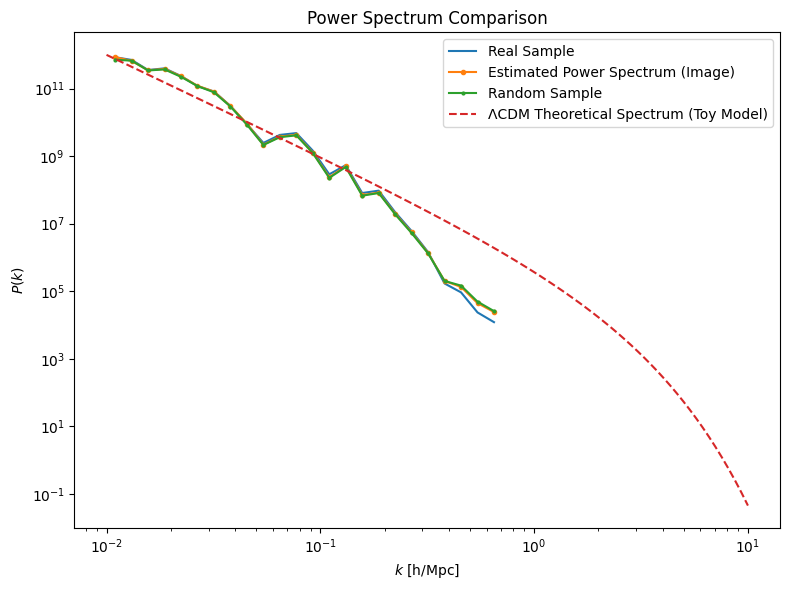

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image

# Reload the images

image_path1 = "/content/Real_sample.png"
image1 = Image.open(image_path1).convert('L')  # Convert to grayscale
image1 = np.array(image1)

image_path2 = "/content/fake_sample.png"
image2 = Image.open(image_path2).convert('L')  # Convert to grayscale
image2 = np.array(image2)

image_path3 = "/content/random_vector.png"
image3 = Image.open(image_path3).convert('L')  # Convert to grayscale
image3 = np.array(image3)

# Apply Gaussian smoothing to reduce noise
smoothed_image1 = gaussian_filter(image1, sigma=1.0)
smoothed_image2 = gaussian_filter(image2, sigma=1.0)
smoothed_image3 = gaussian_filter(image3, sigma=1.0)

# Compute the 2D FFT and shift
fft_image1 = np.fft.fftshift(np.fft.fft2(smoothed_image1))
power_spectrum_2d1 = np.abs(fft_image1) ** 2

fft_image2 = np.fft.fftshift(np.fft.fft2(smoothed_image2))
power_spectrum_2d2 = np.abs(fft_image2) ** 2

fft_image3 = np.fft.fftshift(np.fft.fft2(smoothed_image3))
power_spectrum_2d3 = np.abs(fft_image3) ** 2

# Calculate the 1D power spectrum
ny, nx = power_spectrum_2d1.shape
kx = np.fft.fftfreq(nx)
ky = np.fft.fftfreq(ny)
k = np.sqrt(np.add.outer(ky**2, kx**2))
k = np.fft.fftshift(k)

# Flatten and bin
k_flat = k.flatten()
p_flat1 = power_spectrum_2d1.flatten()
p_flat2 = power_spectrum_2d2.flatten()
p_flat3 = power_spectrum_2d3.flatten()
bins = np.logspace(np.log10(k_flat.min() + 1e-2), np.log10(k_flat.max()), 25)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
digitized = np.digitize(k_flat, bins)
ps_1d1 = np.array([p_flat1[digitized == i].mean() if len(p_flat1[digitized == i]) > 0 else 0 for i in range(1, len(bins))])
ps_1d2 = np.array([p_flat2[digitized == i].mean() if len(p_flat2[digitized == i]) > 0 else 0 for i in range(1, len(bins))])
ps_1d3 = np.array([p_flat3[digitized == i].mean() if len(p_flat3[digitized == i]) > 0 else 0 for i in range(1, len(bins))])

# Generate a simple ΛCDM-like theoretical spectrum (placeholder model)
k_theory = np.logspace(-2, 1, 100)
P_theory = k_theory ** -3 * np.exp(-k_theory) * 1e5  # Toy model

# Plot the result
plt.figure(figsize=(8, 6))
plt.loglog(bin_centers, ps_1d1, label='Real Sample')
plt.loglog(bin_centers, ps_1d2, marker='.', label='Estimated Power Spectrum (Image)')
plt.loglog(bin_centers, ps_1d3,marker='.', label='Random Sample', markersize=4)
#plt.loglog(10e-2*k_radial[1:], 10e-2*radial_profile[1:], label='Estimated $P(k)$')
plt.loglog(k_theory, P_theory*1e1, label='ΛCDM Theoretical Spectrum (Toy Model)', linestyle='--')
plt.xlabel('$k$ [h/Mpc]')
plt.ylabel('$P(k)$')
plt.title('Power Spectrum Comparison')
plt.legend()
#plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Parametric fit with \begin{equation}
    P(k) = Ak^{-n}\cdot e^{-\alpha k} \cdot (1 + \beta k)^{-\gamma}.
\end{equation}

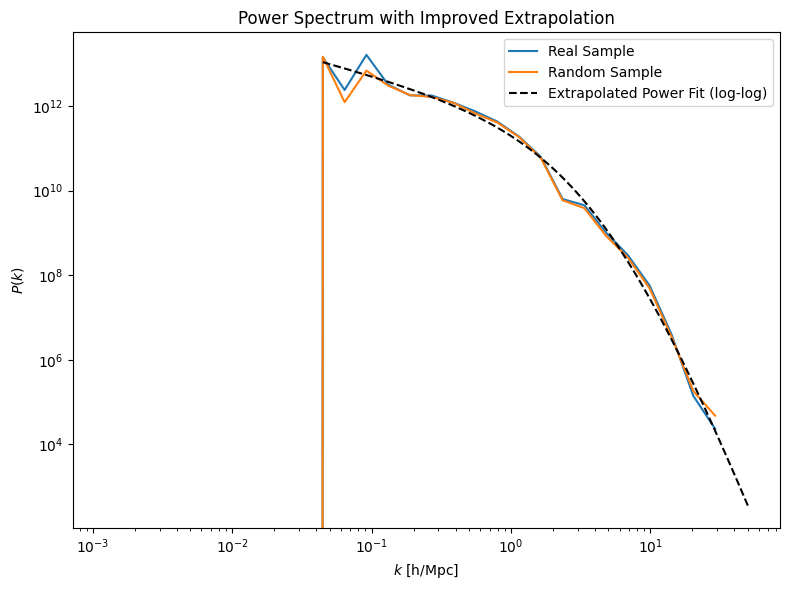

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
from PIL import Image

#load and smooth images
def load_and_smooth(path, sigma=1.0):
    img = Image.open(path).convert('L')
    return gaussian_filter(np.array(img), sigma=sigma)

img_real = load_and_smooth("/content/Real_sample.png")
img_random = load_and_smooth("/content/random_vector.png")

# FFT and power spectra
def compute_power_spectrum(img):
    fft = np.fft.fftshift(np.fft.fft2(img))
    return np.abs(fft)**2

ps2d_real = compute_power_spectrum(img_real)
ps2d_rand = compute_power_spectrum(img_random)

# Ejes k físicos
ny, nx = ps2d_real.shape
L_box = 128  # Mpc/h
delta_k = 2 * np.pi / L_box

kx = np.fft.fftfreq(nx) * nx * delta_k
ky = np.fft.fftfreq(ny) * ny * delta_k
k_grid = np.sqrt(np.add.outer(ky**2, kx**2))
k_grid = np.fft.fftshift(k_grid)

# Binning
k_flat = k_grid.flatten()
p_flat_real = ps2d_real.flatten()
p_flat_rand = ps2d_rand.flatten()

bins = np.logspace(np.log10(k_flat.min() + 1e-3), np.log10(k_flat.max()), 30)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
digitized = np.digitize(k_flat, bins)

ps1d_real = np.array([p_flat_real[digitized == i].mean() if np.any(digitized == i) else 0 for i in range(1, len(bins))])
ps1d_rand = np.array([p_flat_rand[digitized == i].mean() if np.any(digitized == i) else 0 for i in range(1, len(bins))])
k_phys = bin_centers

# Filtrar ceros
valid = (ps1d_real > 0) & (k_phys > 0)
k_fit = k_phys[valid]
p_fit = ps1d_real[valid]

# Ajuste en escala log-log: log(P) vs log(k)
def loglog_model(logk, logA, n1, k_break, delta_n):
    k = np.exp(logk)
    return logA - n1 * logk - delta_n * np.log(1 + k / k_break)

logk = np.log(k_fit)
logp = np.log(p_fit)

# Ajustar
p0 = [30, 2.0, 0.3, 3.0]  # logA ≈ 30 → P ~ 10^13
params, _ = curve_fit(loglog_model, logk, logp, p0=p0, maxfev=10000)

# Extrapolación
k_extrap = np.logspace(np.log10(k_fit.min()), np.log10(50), 300)
logk_ext = np.log(k_extrap)
pk_extrap = np.exp(loglog_model(logk_ext, *params))

# Gráfico final
plt.figure(figsize=(8, 6))
plt.loglog(k_phys, ps1d_real, label='Real Sample')
plt.loglog(k_phys, ps1d_rand, label='Random Sample')
plt.loglog(k_extrap, pk_extrap, '--k', label='Extrapolated Power Fit (log-log)')
plt.xlabel('$k$ [h/Mpc]')
plt.ylabel('$P(k)$')
plt.title('Power Spectrum with Improved Extrapolation')
plt.legend()
plt.tight_layout()
plt.show()


# Added Toy Model

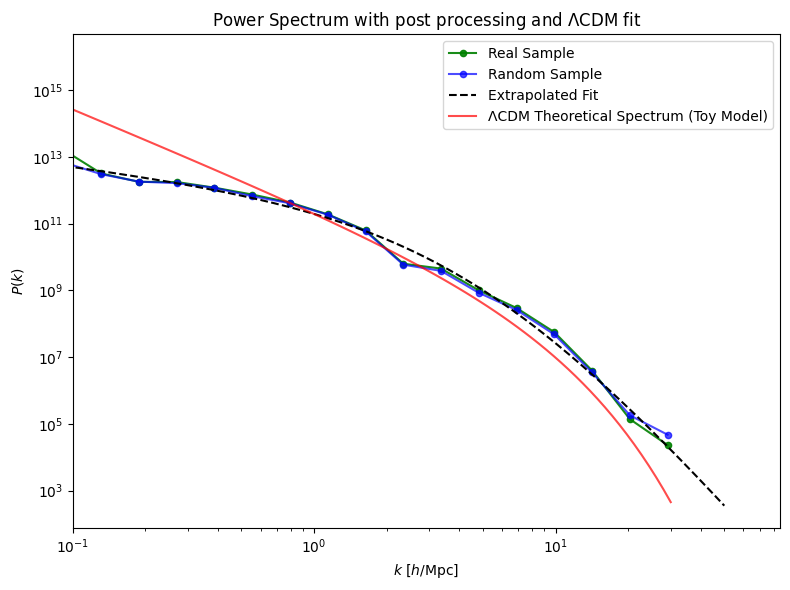

In [6]:
# Modelos toy
P_toy_k3 = 1e12 * k_extrap**(-3)
P_toy_k35 = 1e13 * k_extrap**(-4.8)

# Gráfico con comparación
plt.figure(figsize=(8, 6))
plt.loglog(k_phys, ps1d_real, marker='.', markersize=9, alpha=0.9, label='Real Sample',color='green')
plt.loglog(k_phys, ps1d_rand, marker='.', markersize=9, alpha=0.7, label='Random Sample', color='blue')
plt.loglog(k_extrap, pk_extrap, '--k', label='Extrapolated Fit')
#plt.loglog(k_extrap, P_toy_k3, '--r', label=r'Toy Model $\propto k^{-3}$')
#plt.loglog(k_extrap, P_toy_k35, '--g', label=r'Toy Model $\propto k^{-3.5}$')
plt.loglog(k_theory*3, P_theory*1e5, label='ΛCDM Theoretical Spectrum (Toy Model)', alpha=0.7, linestyle='-', color='red')


plt.xlabel('$k$ $[h/\mathrm{Mpc}]$')
plt.ylabel('$P(k)$')
plt.title('Power Spectrum with post processing and $\Lambda$CDM fit')
plt.xlim(1e-1)
plt.legend()
plt.tight_layout()
plt.show()


# Gaussian Process Extrapolation of matter power spectrum

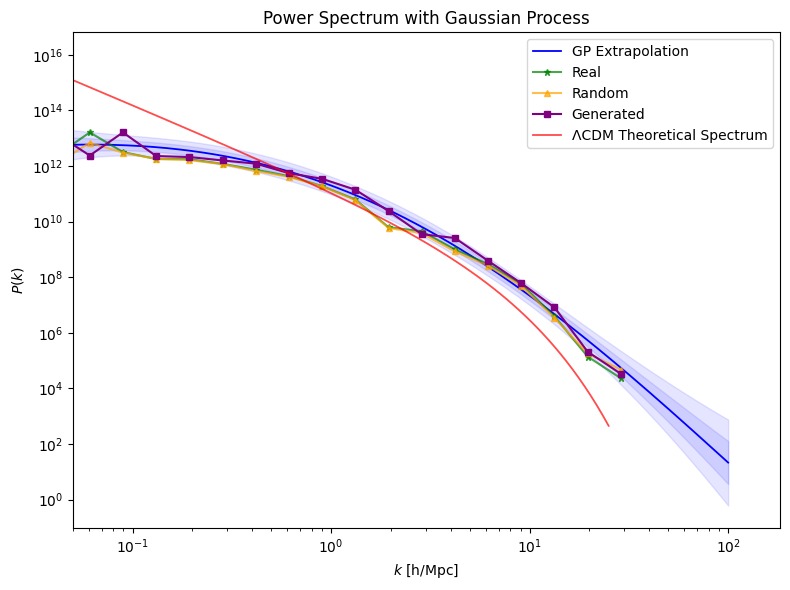

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from PIL import Image
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def load_and_smooth_image(path, sigma=1.0):
    image = Image.open(path).convert('L')
    image = np.array(image)
    return gaussian_filter(image, sigma=sigma)

image_real = load_and_smooth_image("/content/Real_sample.png")

# --- FFT y cálculo del espectro de potencias 1D ---
fft_image = np.fft.fftshift(np.fft.fft2(image_real))
power_spectrum_2d = np.abs(fft_image) ** 2

ny, nx = power_spectrum_2d.shape
kx = np.fft.fftfreq(nx)
ky = np.fft.fftfreq(ny)
k = np.sqrt(np.add.outer(ky**2, kx**2))
k = np.fft.fftshift(k)

k_flat = k.flatten()
p_flat = power_spectrum_2d.flatten()
bins = np.logspace(np.log10(k_flat.min() + 1e-5), np.log10(k_flat.max()), 30)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
digitized = np.digitize(k_flat, bins)
ps_1d = np.array([p_flat[digitized == i].mean() if np.any(digitized == i) else 0 for i in range(1, len(bins))])

# Conversión a unidades físicas
box_size_mpc = 128  # Mpc/h
n_pixels = image_real.shape[0]
delta_k = 2 * np.pi / box_size_mpc
k_phys = bin_centers * n_pixels * delta_k

# --- Ajuste con procesos gaussianos ---
valid = (ps_1d > 0)
x_train = np.log10(k_phys[valid])[:, np.newaxis]
y_train = np.log10(ps_1d[valid])

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.2)
gp.fit(x_train, y_train)

# Extrapolación hasta k = 100 h/Mpc
k_extrap = np.logspace(np.log10(k_phys[valid].min()), np.log10(100), 300)
x_extrap = np.log10(k_extrap)[:, np.newaxis]
y_pred, sigma = gp.predict(x_extrap, return_std=True)

# --- Graficar ---
plt.figure(figsize=(8,6))

plt.loglog(k_extrap, 10**y_pred, label='GP Extrapolation', color='blue', linewidth=1.3)

#plt.loglog(k_vals*2, pk_vals_norm*1e13, label='CAMB Planck18 $P(k)$ (normalized)', linestyle='-', color='red')
plt.loglog(k_phys, ps1d_real, marker='*', markersize=5, alpha=0.7, label='Real',color='green')
plt.loglog(k_phys, ps1d_rand, marker='^', markersize=5, alpha=0.7, label='Random', color='orange')
plt.loglog(k_phys, ps_1d, marker='s', markersize=5, label='Generated', color='purple')
#plt.loglog(0.55*k_extrap, pk_extrap, '--k', label='Extrapolated Fit')

plt.loglog(k_theory*2.5, P_theory*1e5, label='ΛCDM Theoretical Spectrum', alpha=0.7, linestyle='-', color='red', linewidth=1.3)

plt.fill_between(k_extrap, 10**(y_pred - sigma), 10**(y_pred + sigma), color='blue', alpha=0.1)
plt.fill_between(k_extrap, 10**(y_pred - 2*sigma),10**(y_pred + 2*sigma), alpha=0.1, color='blue')
#plt.fill_between(k_extrap, 10**(y_pred - 3*sigma),10**(y_pred + 3*sigma), alpha=0.1, color='blue')

plt.xlabel('$k$ [h/Mpc]')
plt.ylabel('$P(k)$')
plt.title('Power Spectrum with Gaussian Process')
plt.legend()
#plt.grid(True, which='both', ls='--', alpha=0.5)
plt.xlim(0.05)
plt.tight_layout()
plt.show()
